In [1]:
% pylab inline
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
from utils import nn_l2_mean
slim = tf.contrib.slim
ds = tf.contrib.distributions
# from universal_divergence import estimate

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Populating the interactive namespace from numpy and matplotlib


/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
tf.reset_default_graph()


### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [4]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [5]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-4.5,4.5,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Hyperparam

In [6]:
params = dict(
    batch_size=512,
    learning_rate_1=1e-3,
    learning_rate_2=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=20000,
    viz_every=2000,
    z_dim=256,
    x_dim=2,
    optimizer='panayo adam', # rmsprop sgd sga
    reg_w=10.
)

## Function for Symplectic gradient adjustment

## Construct model and training ops

In [45]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

if params['optimizer'] == 'rmsprop':
    print('sgd')
    g_train_opt = tf.train.RMSPropOptimizer(params['gen_learning_rate'])
    d_train_opt = tf.train.RMSPropOptimizer(params['disc_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    train_op = tf.group(g_train_op, d_train_op)
    
elif params['optimizer'] == 'panayo adam':
    print('panayo')  
    '''
    1) copy w to wcopy
    2) compute grad(loss,w) and update w 
    3) compute grad(loss,wprim)
    4) restore w with wcopy
    4) apply gradprim to w
    '''
    with tf.variable_scope('var_prim'):
        disc_vprim = [tf.Variable(var.initialized_value()) for var in disc_vars]
        gen_vprim = [tf.Variable(var.initialized_value()) for var in gen_vars]
    
    varprim = disc_vprim + gen_vprim
    variables = disc_vars + gen_vars

    copy_w_to_wprim = [wprim.assign(w) for wprim,w in zip(varprim,variables)] # assign w to wprim
    restore_ops = [w.assign(wprim) for wprim,w in zip(varprim,variables)]
    
    optimizer1 = tf.train.RMSPropOptimizer(1e-4)
    optimizer2 = tf.train.RMSPropOptimizer(1e-4)

#     optimizer1 = tf.train.AdamOptimizer(1e-4)
#     optimizer2 = tf.train.AdamOptimizer(1e-4)
     
    d_grads = tf.gradients(loss, disc_vars)
    g_grads = tf.gradients(-loss, gen_vars)
    grads = d_grads + g_grads
    
    g_w = [(g, v)for (g, v) in zip(grads, variables)]
    
    g_wprim = [(g, v.assign(vprim))for (g, v, vprim) in zip(grads, variables, varprim)]

    trigger_grad = tf.identity_n(g_w)
    
    with tf.control_dependencies(copy_w_to_wprim):
        update_future = optimizer1.apply_gradients(g_w) # update wprim with grad_w
    
#     with tf.control_dependencies(trigger_grad): # compute gradprim
#         with tf.control_dependencies(restore_ops): # restor w          GIVE DECENT RESULTS
#             update = optimizer2.apply_gradients(g_w)        

    update = optimizer2.apply_gradients(g_wprim)        
          
    
elif params['optimizer'] == 'panayo sgd':

    variables = disc_vars + gen_vars


    d_grads = tf.gradients(loss, disc_vars)
    g_grads = tf.gradients(-loss, gen_vars)
    grads = d_grads + g_grads
    
    varcopy_updates = []
    var_updates = []
    for grad, varcopy, var in zip(grads, variables_copy, variables):
        varcopy_updates.append(varcopy.assign(var))
        var_updates.append(var.assign(var - params['learning_rate_1'] * grad))
    update = varcopy_updates + var_updates
    train_op_inter = tf.group(*update)
    
    var_updates = []
    for grad, varcopy, var in zip(grads, variables_copy, variables):
        var_updates.append(var.assign(varcopy - params['learning_rate_2'] * grad))
    
    with tf.control_dependencies([train_op_inter]):
        train_op = tf.group(*var_updates)


panayo


NotImplementedError: ('Trying to optimize unsupported type ', <tf.Tensor 'Assign_56:0' shape=(2, 384) dtype=float32_ref>)

## Train

In [ ]:
# config = tf.ConfigProto(device_count={'GPU': 0})
# config.gpu_options.allow_growth = True
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
    g_wprim = [(g, v.assign(varprim))for (g, v) in zip(grads, variables, varprim)]


  0%|          | 0/20001 [00:00<?, ?it/s]

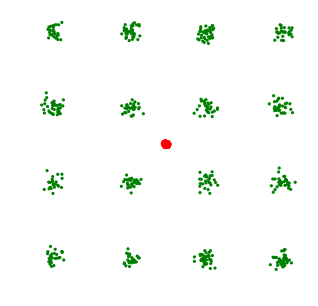

  2%|▏         | 499/20001 [00:15<10:23, 31.26it/s]

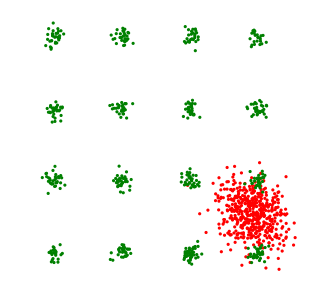

  5%|▍         | 1000/20001 [00:31<10:00, 31.62it/s]

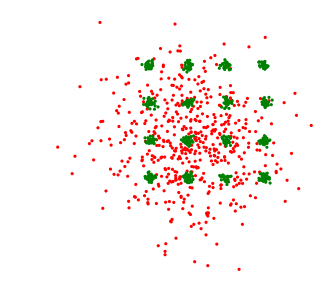

  7%|▋         | 1498/20001 [00:47<09:44, 31.68it/s]

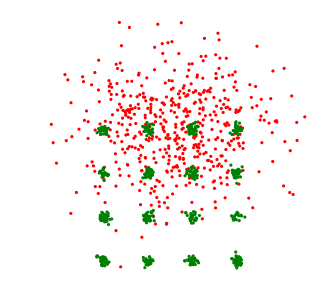

 10%|▉         | 2000/20001 [01:04<09:37, 31.19it/s]

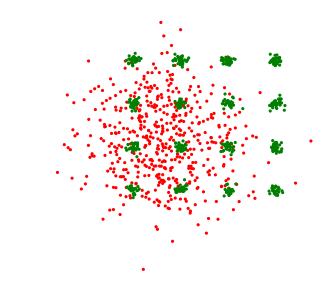

 12%|█▏        | 2497/20001 [01:20<09:24, 31.03it/s]

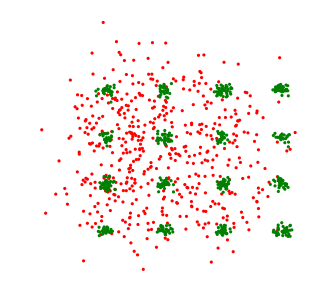

 15%|█▍        | 3000/20001 [01:37<09:12, 30.75it/s]

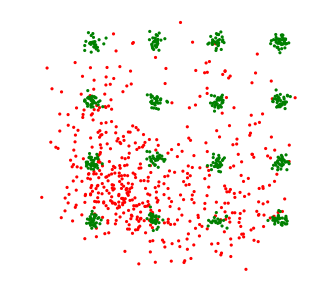

 17%|█▋        | 3500/20001 [01:54<08:59, 30.61it/s]

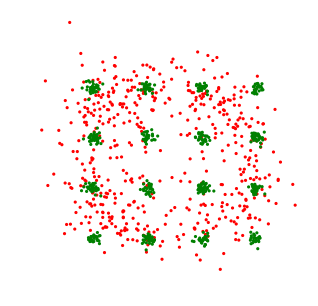

 20%|█▉        | 3998/20001 [02:10<08:42, 30.62it/s]

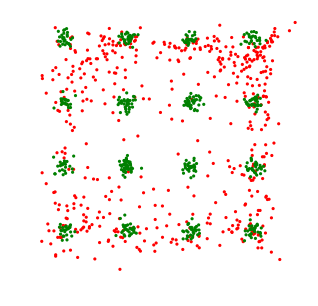

 22%|██▏       | 4497/20001 [02:27<08:27, 30.58it/s]

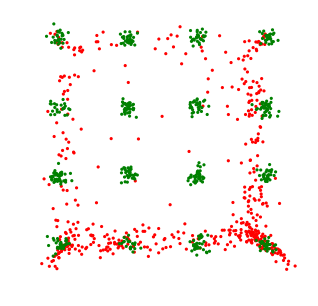

 25%|██▍       | 5000/20001 [02:44<08:12, 30.47it/s]

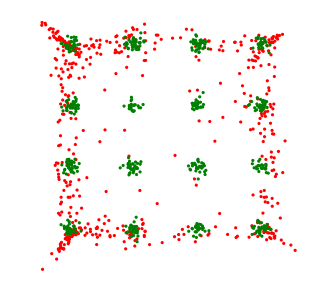

 27%|██▋       | 5499/20001 [03:01<07:59, 30.26it/s]

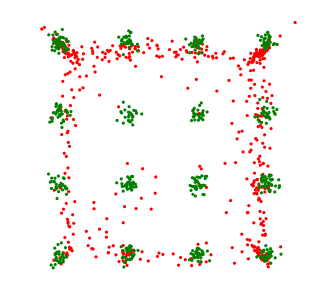

 30%|██▉       | 6000/20001 [03:17<07:39, 30.44it/s]

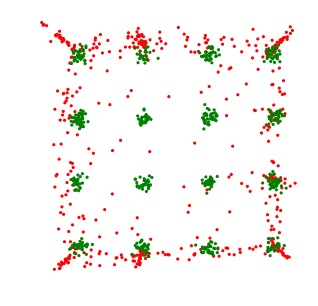

 32%|███▏      | 6497/20001 [03:31<07:19, 30.73it/s]

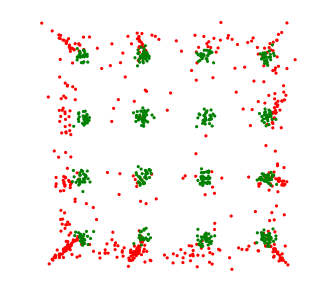

 35%|███▍      | 6999/20001 [03:59<07:24, 29.26it/s]

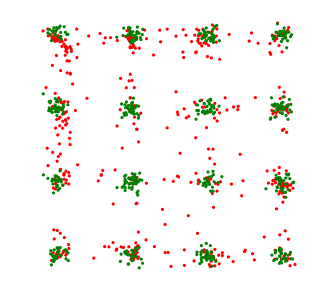

 37%|███▋      | 7500/20001 [04:22<07:17, 28.56it/s]

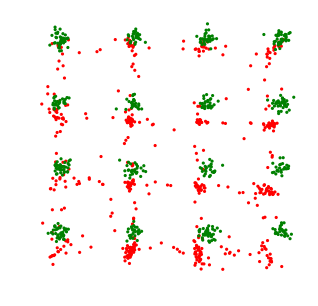

 40%|███▉      | 7998/20001 [04:39<07:00, 28.57it/s]

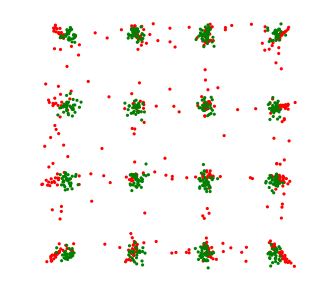

 42%|████▏     | 8496/20001 [04:53<06:37, 28.91it/s]

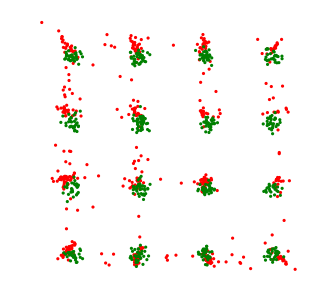

 45%|████▍     | 8998/20001 [05:07<06:15, 29.30it/s]

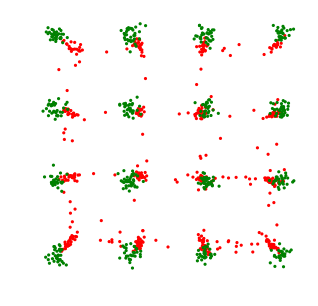

 47%|████▋     | 9500/20001 [05:22<05:56, 29.43it/s]

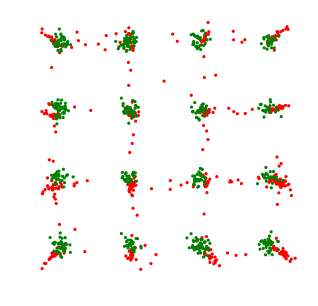

 50%|████▉     | 9999/20001 [05:37<05:37, 29.62it/s]

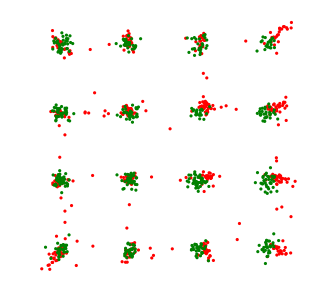

 52%|█████▏    | 10499/20001 [05:52<05:19, 29.78it/s]

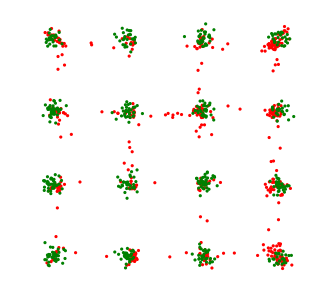

 55%|█████▍    | 11000/20001 [06:07<05:00, 29.93it/s]

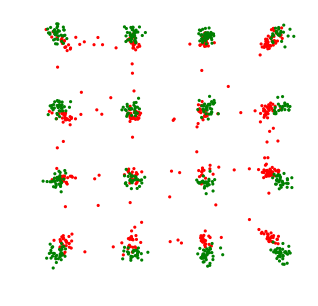

 57%|█████▋    | 11496/20001 [06:22<04:43, 30.02it/s]

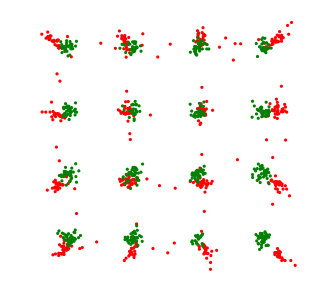

 60%|█████▉    | 11998/20001 [06:37<04:24, 30.21it/s]

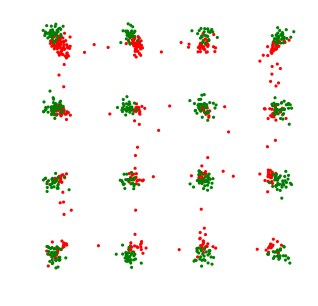

 62%|██████▏   | 12498/20001 [06:53<04:08, 30.24it/s]

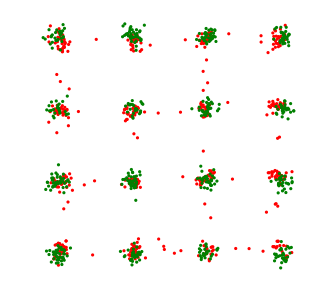

 65%|██████▍   | 12997/20001 [07:08<03:50, 30.34it/s]

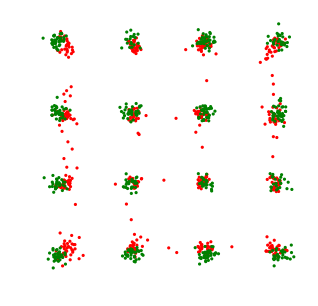

 67%|██████▋   | 13500/20001 [07:24<03:33, 30.40it/s]

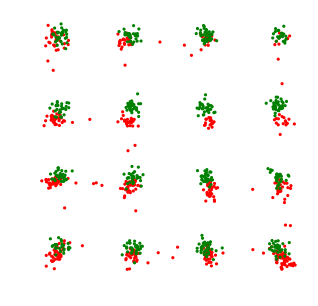

 70%|██████▉   | 13997/20001 [07:39<03:17, 30.46it/s]

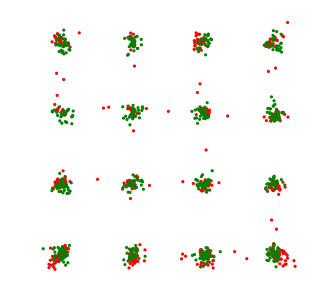

 72%|███████▏  | 14497/20001 [07:53<02:59, 30.60it/s]

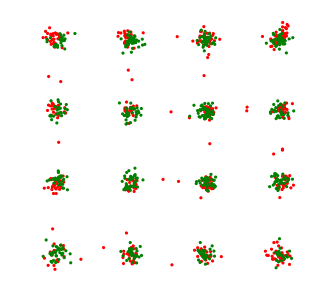

 75%|███████▍  | 14997/20001 [08:08<02:42, 30.72it/s]

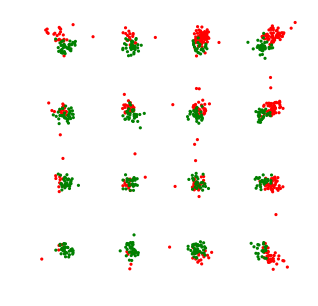

 75%|███████▌  | 15028/20001 [08:09<02:41, 30.72it/s]

KeyboardInterrupt: 

In [42]:
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
nn_every = 200
y_ref = sess.run( data)
nn_dist = []
nn_kl =[]
for i in tqdm(range(params['max_iter']+1)):
#     f, _, _ = sess.run([[loss], g_train_op, d_train_op])
#     f, _= sess.run([[loss], train_op])
    sess.run(update_future)
    sess.run(update)
#     fs.append(f)
    if (i) % viz_every == 0:
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], c='r',edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
        axis('off')
        show()
        
#     if (i) % nn_every == 0:
#         x = np.vstack([sess.run(samples) for _ in range(n_batches_viz)])
#         l2nn = nn_l2_mean(x,y_ref)
#         kl =estimate(x, y_ref,k=1)
#         nn_dist.append(l2nn)
#         nn_kl.append(kl)
#         print('dist = ', l2nn)
#         print('kl = ', kl)

 75%|███████▌  | 15028/20001 [08:20<02:45, 30.05it/s]

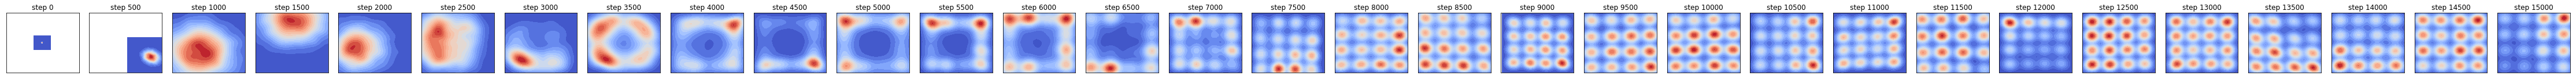

In [43]:
np_samples_ = np_samples[::1]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
#     ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-6,6]]*2)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='coolwarm',bw=.40, n_levels=20, clip=[[-6,6]]*2)

#     ax2.set_axis_bgcolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*viz_every))
gcf().tight_layout()

In [ ]:
plt.semilogy(nn_dist)
plt.semilogy(nn_kl)
plt.legend(['kl','l2 nearest neigbhors'])
xlabel('iterations')
plt.show()

In [11]:
np.save('plot_con_kl',nn_kl)
np.save('plot_con_nn',nn_dist)